In [217]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tobler.dasymetric import masked_area_interpolate
from tobler.model import glm
from tobler.area_weighted import area_interpolate
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [218]:
def read_table (file_name, sheet=0, header_row=0):
    split_name = file_name.split(".")
    file_type = split_name[len(split_name)-1]
    file =  pd.DataFrame(columns=['colum'])
    if file_type == 'xls' or file_type == 'xlsx' :
        file = pd.read_excel (file_name, sheet_name = sheet, header = header_row)
    elif file_type == 'csv':
        file = pd.read_csv(file_name)
    return file

In [281]:
def load_trim_attr(file_name, columns, filter_path, column_name, sheet=0, header_row=0, code = 0):
    #read attribute file
    file = read_table(file_name, sheet, header_row)
    #read filter units file
    filter_units = read_table(filter_path)
    code_header = filter_units.columns[code]
    filter_units[[code_header]]=filter_units[[code_header]].astype(str)
    #Select only code of the geographic units and the number of dwellings as columns
    cols= [list(file.columns)[i] for i in columns]
    file_cols=file[cols]
    #Rename columns
    file_cols.columns = [code_header, cols[1]]
    #Drop NaNs
    file_cols.dropna(inplace =True)
    #Delete blank spaces in the string
    file_cols[code_header] = file_cols[code_header].astype(str)
    file_cols[code_header] = file_cols[code_header].str.replace(' ', '')
    #Get only building permits from Greater Melbourne's geographic units
    result = pd.merge(file_cols, filter_units, how="right", on=code_header)
    #Name number of building permits with the finantial year period
    result.rename(columns={cols[1]: column_name}, inplace=True)
    return result

# 1. Fill out paths, variable and mask

In [403]:
####################################################
################## Fill out manually ###############
crs = 7899
source_shp_path = 'Shapefiles/un-trimmed/SA2_2011_Australia/SA2_2011_AUST.shp'
target_shp_path = 'Shapefiles/Great_Melbourne/SA1_2016_GM/SA1_2016_GM.shp'
attribute_path = 'Gentrification_Labels/House_Prices/mean_median_SA2_2011/house_prices_2016.csv'
attribute_name = 'House_Price_2016'
columns_of_interest = [0,13]
sheet_number = 0
header_row = 0
filter_path = 'Geographical_Units/Great_Melbourne_Units/SA2_2011_GM.csv'
code_column = 0
####################################################

# 2. Trim attribute using source geographic-division mask

In [404]:
source_shp = gpd.read_file(source_shp_path).to_crs(crs)
target_shp = gpd.read_file(target_shp_path).to_crs(crs)

filtered_attr = load_trim_attr(attribute_path, columns_of_interest, filter_path, 
                               attribute_name, sheet_number, header_row, code = code_column)

In [405]:
filtered_attr.head()

,SA2_MAINCODE_2011,House_Price_2016,SA2_NAME_2011,SA2_5DIGITCODE_2011,SA3_CODE_2011,SA3_NAME_2011,SA4_CODE_2011,SA4_NAME_2011,GCCSA_CODE_2011,GCCSA_NAME_2011,STATE_CODE_2011,STATE_NAME_2011,AREA_ALBERS_SQM
0,206011105,749463.541667,Brunswick,21105,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,5142469.999
1,206011106,777041.666667,Brunswick East,21106,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,2168041.951
2,206011107,702916.666667,Brunswick West,21107,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,3179281.678
3,206011108,674164.125000,Coburg,21108,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,6933716.816
4,206011109,685833.333333,Pascoe Vale South,21109,20601,Brunswick - Coburg,206,Melbourne - Inner,2GMEL,Greater Melbourne,2,Victoria,2989804.922


# 3. Join trimmed  attribute to source shapefile

In [406]:
print(filtered_attr.columns)
source_shp.head()

Index(['SA2_MAINCODE_2011', 'House_Price_2016', 'SA2_NAME_2011',
       'SA2_5DIGITCODE_2011', 'SA3_CODE_2011', 'SA3_NAME_2011',
       'SA4_CODE_2011', 'SA4_NAME_2011', 'GCCSA_CODE_2011', 'GCCSA_NAME_2011',
       'STATE_CODE_2011', 'STATE_NAME_2011', 'AREA_ALBERS_SQM'],
      dtype='object')


,SA2_MAIN11,SA2_5DIG11,SA2_NAME11,SA3_CODE11,SA3_NAME11,SA4_CODE11,SA4_NAME11,GCC_CODE11,GCC_NAME11,STE_CODE11,STE_NAME11,ALBERS_SQM,geometry
0,101011001,11001,Goulburn,10101,Goulburn - Yass,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.464426e+07,"POLYGON ((2935417.379 2744252.738, 2935541.508..."
1,101011002,11002,Goulburn Region,10101,Goulburn - Yass,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9.035115e+09,"POLYGON ((2964875.305 2768265.709, 2964871.670..."
2,101011003,11003,Yass,10101,Goulburn - Yass,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9.973385e+07,"POLYGON ((2853507.735 2735753.727, 2853454.950..."
3,101011004,11004,Yass Region,10101,Goulburn - Yass,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,5.681965e+09,"POLYGON ((2807620.652 2744989.273, 2807271.444..."
4,101011005,11005,Young,10101,Goulburn - Yass,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,5.057537e+08,"POLYGON ((2794518.618 2785414.523, 2794121.598..."


In [407]:
####################################################
################## Fill out manually ###############
pivot_col = 'SA2_MAINCODE_2011'
shp_pivot_col = 'SA2_MAIN11'
####################################################

In [408]:
#unify pivot columns' name
source_shp.rename(columns={shp_pivot_col: pivot_col}, inplace=True)
#Cast codes to string
source_shp[[pivot_col]] = source_shp[[pivot_col]].astype(str)
filtered_attr[[pivot_col]] = filtered_attr[[pivot_col]].astype(str)
#join
source_shp_attr = source_shp.merge(filtered_attr, on=pivot_col, how="right")

# 4. Areal Interpolation

In [409]:
source_shp_attr[attribute_name] = pd.to_numeric(source_shp_attr[attribute_name])
interpolated_attr = area_interpolate(source_df=source_shp_attr, target_df=target_shp,
                                     intensive_variables=[attribute_name])

In [410]:
interpolated_attr.head()

,House_Price_2016,geometry
0,749463.577355,"POLYGON ((2497503.256 2415721.308, 2497439.107..."
1,749463.541667,"POLYGON ((2496812.542 2415561.087, 2496919.286..."
2,749463.541667,"POLYGON ((2497166.784 2415362.251, 2497186.791..."
3,749463.598956,"POLYGON ((2497463.070 2415179.114, 2497530.543..."
4,749463.541667,"POLYGON ((2497040.069 2415051.054, 2497049.708..."


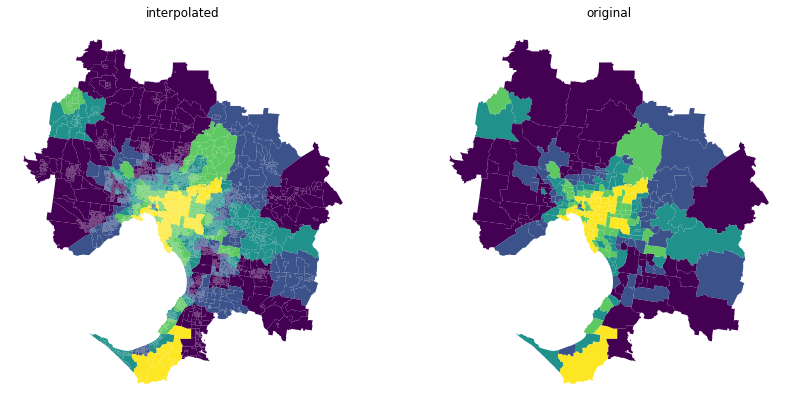

In [411]:
import mapclassify.classifiers as classifiers
fig, ax = plt.subplots(1,2, figsize=(14,7))

interpolated_attr.plot(attribute_name, scheme='quantiles',  ax=ax[0])
source_shp_attr.plot(attribute_name, scheme='quantiles',  ax=ax[1])

ax[0].set_title('interpolated')
ax[1].set_title('original')
for ax in ax:
    ax.axis('off')

<AxesSubplot:ylabel='Frequency'>

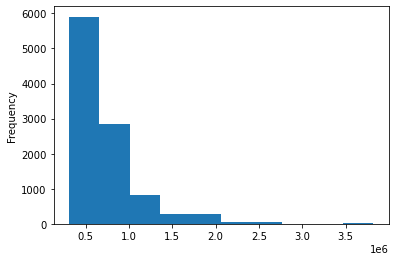

In [412]:
interpolated_attr[attribute_name].plot(kind="hist")

# 5. Save File

In [413]:
polygons_column = interpolated_attr.geometry.name
interpolated_attr = interpolated_attr.merge(target_shp, on=polygons_column, how='left')
interpolated_attr.drop([polygons_column], axis=1, inplace = True)
interpolated_attr.to_csv('Gentrification_Labels/House_Prices/Geopandas_Interpolated/'+
                        attribute_name + '.csv', index=False)